# Datasets

In [70]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import load_svmlight_file
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import os
import time

# K-Means Clustering Algorithm

## Implementation

We implement the class `KMeanClustering`. The implementation of the cluster-kmeans algorithm is in the `fit` method.

In [71]:
class KMeanClustering:
    def __init__(self, K, epsilon=1e-5, max_iter=200):
        if K < 1:
            raise ValueError("K must be greater than 0. Clustering requires at least one Cluster.")
        self.K = K
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.mu = None
        self.P = None
        self.inertia_ = None

    def fit(self, X):
        N, M = X.shape
        mu = np.zeros((self.K, M))

        mu[0] = X[np.random.randint(0, N)]

        for k in range(1, self.K):
            distances = np.zeros(N)

            for i, x in enumerate(X):
                distances[i] = np.sum([np.linalg.norm(x - mu[j]) for j in range(k)])

            i_k = np.argmax(distances)
            mu[k] = X[i_k]

        for epoch in range(self.max_iter):
            mu_old = mu.copy()
            self.P = np.zeros(N, dtype=int)

            for n in range(N):
                distances_to_centroids = [np.linalg.norm(X[n] - mu[k]) for k in range(self.K)]
                self.P[n] = np.argmin(distances_to_centroids)

            for k in range(self.K):
                points_in_cluster = X[self.P == k]
                if len(points_in_cluster) > 0:
                    mu[k] = np.mean(points_in_cluster, axis=0)

            centroid_shift = np.linalg.norm(mu - mu_old, axis=1).mean()
            if centroid_shift < self.epsilon:
                break
        else:
            print('WARNING: Centroid shift convergence not reached.')

        self.mu = mu

        self.inertia_ = sum(np.linalg.norm(X[n] - mu[self.P[n]]) ** 2 for n in range(N))

    def predict(self, X):
        predictions = np.zeros(len(X), dtype=int)
        for n in range(len(X)):
            distances_to_centroids = [np.linalg.norm(X[n] - self.mu[k]) for k in range(self.K)]
            predictions[n] = np.argmin(distances_to_centroids)
        return predictions

## Evaluation

According to the sheet, we can decide whether to use $D_1$ or $D_2$, so we decide to use the iris dataset $D_1$.

We use `fetch_iris` from `data_handler` to fetch the dataset and `load_svmlight_file` from `sklearn.datasets` to load the file. In `handle_sparsity`, we calculate the sparsity and convert the data to a dense numpy array.

In [72]:
from data_handler import fetch_iris

iris_path = 'data/iris/iris.scale'

fetch_iris(iris_path)

D1_data, D1_labels = load_svmlight_file(iris_path)


def handle_sparsity(X):
    zero_portion = 1 - X.nnz / (X.shape[0] * X.shape[1])
    print(f"Sparsity: {zero_portion:.2%}")

    return X.toarray()  # convert to numpy array and convert to dense array.


D1_data = handle_sparsity(D1_data)

File downloaded and saved as data/iris/iris.scale
Sparsity: 2.17%


### Elbow-Method

Capturing the accuracy does not work to measure the model's performance, because of the **unsupervised** algorithm, so the cluster labels generated my K-Means do not necessarily match the original class labels. As [this article](https://opendatascience.com/unsupervised-learning-evaluating-clusters/) from opendatasience.com suggests, we use the **Elbow Method** to choose the optimal value for $K$.

For each $K$, we calculate the Interia (Already implemented in the `KMeanClustering` class)
$$
\text{Inertia} = \sum_{k=1}^K \sum_{x_i \in C_k} \| x_i - \mu_k \|^2
$$
and plot it to find the "elbow".

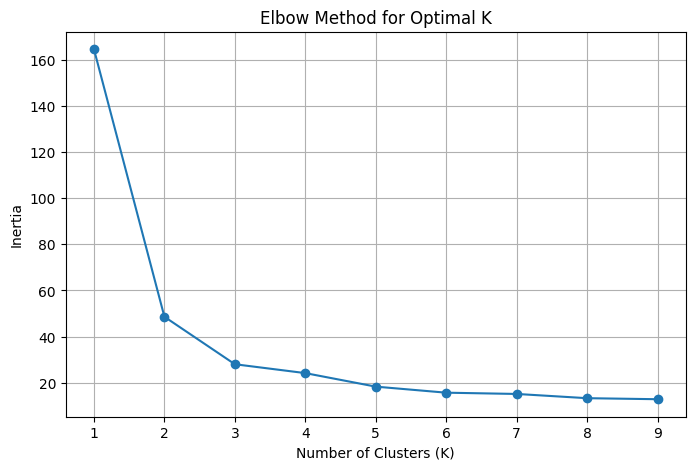

In [73]:
def cluster_elbow(data, Ks):
    inertias = []

    for K in Ks:
        model = KMeanClustering(K)
        model.fit(data)

        inertias.append(model.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(Ks, inertias, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show()


cluster_elbow(D1_data, range(1, 10))

In this figure, we can see a sharp decrease between $K = 1$ and $K = 2$. This indicates a a significant improvement when moving from 1 to 2 clusters. A noticeable "elbow" appears around $K = 3$, where the rate of decrease slows down. Beyond $K = 3$, there are only slight reductions, suggesting the "elbow" point is likely at $K = 3$.

Since we know the actual number of unique labels, we can approve the optimal value for $K$ is indeed $3$.

In general, there is justified criticism of the elbow method because it is considered "both subjective and unreliable" ([Wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering))).

# Cluster News Articles

## Pre-Processing
We pre-process the data. First, we load the dataset from the provided directories. Then, we vectorize the text data to convert the documents into numerical feature representations. Since the resulting feature space is high-dimensional, we apply dimensionality reduction. Finally, we store the processed data in the LIBSVM format to simplify future loading and avoid repeated pre-processing.

### Loading the data

First, we load the 20Newsgroups dataset from the train and test directories.

In [74]:
def load_texts(path):
    labels = []
    texts = []
    label_names = []

    for label_idx, category in enumerate(sorted(os.listdir(path))):
        category_path = os.path.join(path, category)

        label_names.append(category)

        for file_name in sorted(os.listdir(category_path)):
            file_path = os.path.join(category_path, file_name)

            with open(file_path, 'r') as f:
                texts.append(f.read())
                labels.append(label_idx)

    return labels, texts, label_names

### Vectorization

Like last week, we use `TfidfVectorizer` from sklearn's feature extraction with stop word removal.

In [75]:
def vectorize_texts(train_texts, test_texts):
    vectorizer = TfidfVectorizer(stop_words='english')

    X_train_tfidf = vectorizer.fit_transform(train_texts)
    X_test_tfidf = vectorizer.transform(test_texts)

    return X_train_tfidf, X_test_tfidf

### Dimensionality Reduction

Since these are way to many dimensions, we reduce the dimensionality like last week using `TruncatedSVD` from sklearn's decomposition.

In [76]:
def reduce_dimensions(X_train_tfidf, X_test_tfidf):
    svd = TruncatedSVD(n_components=1000, random_state=42)

    X_train_reduced = svd.fit_transform(X_train_tfidf)
    X_test_reduced = svd.transform(X_test_tfidf)

    return X_train_reduced, X_test_reduced

### Store in LIBSVM Format

Lastly, we store the data in the LIBSVM file format. Luckily, we have an implementation for that from last week as well :) We just need minor changes to properly iterate through the non-zero elements.

In [77]:
def to_LIBSVM(data, labels, file_name):
    with open(file_name, 'w') as f:
        for i, row in enumerate(data):
            label = labels[i]
            non_zero = zip(np.nonzero(row)[0], row[np.nonzero(row)])
            features = ' '.join(f'{j + 1}:{v}' for j, v in non_zero)
            f.write(f'{label} {features}\n')

### Retrieving Preprocessed Data

To avoid repeated pre-processing, we pre-process the data once and save it in the LIBSVM file format. Then we load the data from the files.

In [78]:
PATH_TRAIN = 'data/20news-bydate/20news-train-preprocessed-libsvm.txt'
PATH_TEST = 'data/20news-bydate/20news-test-preprocessed-libsvm.txt'

if not os.path.exists(PATH_TRAIN) or not os.path.exists(PATH_TEST):
    train_labels, train_texts, label_names = load_texts('data/20news-bydate/20news-bydate-train')
    test_labels, test_texts, _ = load_texts('data/20news-bydate/20news-bydate-test')

    X_train_tfidf, X_test_tfidf = vectorize_texts(train_texts, test_texts)

    X_train_reduced, X_test_reduced = reduce_dimensions(X_train_tfidf, X_test_tfidf)

    to_LIBSVM(X_train_reduced, train_labels, PATH_TRAIN)
    to_LIBSVM(X_test_reduced, test_labels, PATH_TEST)

D3_data_train, D3_labels_train = load_svmlight_file(PATH_TRAIN)
D3_data_test, D3_labels_test = load_svmlight_file(PATH_TEST)

D3_data_train, D3_data_test = D3_data_train.toarray(), D3_data_test.toarray()

## Clustering with our Implementation

The **adjusted random score** (ARS) measures the similarity between two clusterings ([Wikipedia](https://en.wikipedia.org/wiki/Rand_index)). The score ranges from -1 to 1 where 1 is perfect agreement, 0 is random clustering and -1 is worse than random agreement.

The **Normalized Mutual Information Score** (NMI) measures the mutual dependence between two clusterings ([Wikipedia](https://en.wikipedia.org/wiki/Mutual_information)). The score ranges from 0 to 1 where 1 is perfect agreement and 0 is no shared information.

In [84]:
def cluster_and_measure_quality():
    start_time = time.time()
    model = KMeanClustering(20)
    model.fit(D3_data_train)

    test_predictions = model.predict(D3_data_test)
    end_time = time.time()

    ari_score = adjusted_rand_score(D3_labels_test, test_predictions)
    nmi_score = normalized_mutual_info_score(D3_labels_test, test_predictions)

    print(f'Adjusted Rand Index: {ari_score:.4f}')
    print(f'Normalized Mutual Information: {nmi_score:.4f}')
    print(f'Elapsed Time: {(end_time - start_time):.2f} s')


cluster_and_measure_quality()

Adjusted Rand Index: 0.0025
Normalized Mutual Information: 0.0793
Elapsed Time: 26.32 s


The scores are both very bad. The ARI score suggests that the clustering is almost random. The NMI score suggests that there is almost no shared information. Either the model is very bad, or there are no patterns in the data that the model could recognize.

## Comparison to Sklearn's model

In [85]:
def cluster_and_measure_quality_library():
    start_time = time.time()
    kmeans = KMeans(n_clusters=20, random_state=69)
    kmeans.fit(D3_data_train)

    test_predictions = kmeans.predict(D3_data_test)
    end_time = time.time()

    ari_score = adjusted_rand_score(D3_labels_test, test_predictions)
    nmi_score = normalized_mutual_info_score(D3_labels_test, test_predictions)

    print(f'Adjusted Rand Index: {ari_score:.4f}')
    print(f'Normalized Mutual Information: {nmi_score:.4f}')
    print(f'Elapsed Time: {(end_time - start_time):.2f} s')


cluster_and_measure_quality_library()

Adjusted Rand Index: 0.0674
Normalized Mutual Information: 0.3290
Elapsed Time: 0.78 s


The results for Sklearn’s KMeans are also poor, with low ARI and NMI scores. This indicates either issues in the preprocessing or that no clear patterns exist in the data. However, Sklearn’s model is significantly faster, with an elapsed time about **34 times shorter** than our implementation.


We could improve these results with further feature engineering, but it's already late, and I'm invited to two birthday parties this weekend, and I want to finish the Christmas present for my grandparents.

Wishing you a peaceful holiday season and a Happy New Year!

